In [3]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

c:\Users\Menna\myenv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Menna\myenv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Menna\myenv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runt

In [4]:
BALANCED_DATASET_PATH = "VGGFace2_balanced_900_albumentations"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 15

In [5]:
#  Read image paths and shuffle
all_image_paths = [os.path.join(dp, f) 
                   for dp, dn, fn in os.walk(BALANCED_DATASET_PATH) 
                   for f in fn if f.lower().endswith(('.jpg','.jpeg','.png'))]

random.shuffle(all_image_paths)
total_images = len(all_image_paths)
print(f"Found {total_images} images.")

# Split into train / val / test
train_size = int(0.7 * total_images)
val_size = int(0.15 * total_images)

train_paths = all_image_paths[:train_size]
val_paths = all_image_paths[train_size:train_size+val_size]
test_paths = all_image_paths[train_size+val_size:]

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")


# Map class names to integers
class_names = sorted([d for d in os.listdir(BALANCED_DATASET_PATH) if os.path.isdir(os.path.join(BALANCED_DATASET_PATH, d))])
class_to_int = {name:i for i,name in enumerate(class_names)}


#  Dataset functions
def process_path(file_path):
    """Load image and label."""
    class_name = tf.strings.split(file_path, os.path.sep)[-2]
    label = tf.py_function(lambda x: class_to_int[x.numpy().decode()], [class_name], tf.int32)
    label.set_shape([])
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img, label

def configure_for_performance(ds):
    ds = ds.shuffle(1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def configure_test(ds):
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Create datasets
train_ds = configure_for_performance(tf.data.Dataset.from_tensor_slices(train_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE))
val_ds = configure_for_performance(tf.data.Dataset.from_tensor_slices(val_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE))
test_ds = configure_test(tf.data.Dataset.from_tensor_slices(test_paths).map(process_path, num_parallel_calls=tf.data.AUTOTUNE))

print("Datasets ready.")


Found 13500 images.
Train: 9450, Val: 2025, Test: 2025
Datasets ready.


In [ ]:
#  Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.15),
    layers.RandomBrightness(0.15),
], name="data_augmentation")


#  build MobileNetV2 model
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze the model

inputs = layers.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)  # Normalization [0,1]

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,775 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#  Callbacks
checkpoint = ModelCheckpoint(
    'mobilenetv2_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)


In [ ]:
# 9. Train frozen 
EPOCHS = 50  
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.2316 - loss: 2.3378
Epoch 1: val_accuracy improved from None to 0.53877, saving model to mobilenetv2_best_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 206s 673ms/step - accuracy: 0.3215 - loss: 2.0113 - val_accuracy: 0.5388 - val_loss: 1.4819 - learning_rate: 3.0000e-04
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.4968 - loss: 1.5008
Epoch 2: val_accuracy improved from 0.53877 to 0.63951, saving model to mobilenetv2_best_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 189s 637ms/step - accuracy: 0.5260 - loss: 1.4231 - val_accuracy: 0.6395 - val_loss: 1.1661 - learning_rate: 3.0000e-04
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.5769 - loss: 1.2763
Epoch 3: val_accuracy improved from 0.63951 to 0.65531, saving model to mobilenetv2_best_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 198s 667ms/step - accuracy: 0.5907 - loss: 1.2425 - val_accuracy: 0.6553 - val_loss: 1.0793 - learning_rate: 

# Fine tune the model

In [7]:
ckpt = "mobilenetv2_best_model.keras"

print("Loading Stage-1 model:", ckpt)
model = tf.keras.models.load_model(ckpt)
print("Model loaded successfully!")

Loading Stage-1 model: mobilenetv2_best_model.keras
Model loaded successfully!


In [8]:
# Retrieve the base_model inside it
base_model = None
for layer in model.layers:
    if isinstance(layer, tf.keras.Model) and "mobilenetv2" in layer.name.lower():
        base_model = layer
        break

if base_model is None:
    raise ValueError("Could not find MobileNetV2 inside model.")

In [9]:
# Unfreeze last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Freeze ALL BatchNorm for stability
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

print("Fine-tuning layers prepared.")

Fine-tuning layers prepared.


In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
checkpoint_fine = ModelCheckpoint(
    "mobilenetv2_finetuned.weights.h5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True, #####
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

early_stop_fine = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1
)


In [12]:
fine_tune_epochs = 20

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[checkpoint_fine, reduce_lr, early_stop_fine]
)

Epoch 1/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8243 - loss: 0.5840
Epoch 1: val_accuracy improved from None to 0.87852, saving model to mobilenetv2_finetuned.weights.h5
296/296 ━━━━━━━━━━━━━━━━━━━━ 222s 728ms/step - accuracy: 0.8356 - loss: 0.5449 - val_accuracy: 0.8785 - val_loss: 0.4142 - learning_rate: 1.0000e-05
Epoch 2/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8697 - loss: 0.4625
Epoch 2: val_accuracy improved from 0.87852 to 0.89037, saving model to mobilenetv2_finetuned.weights.h5
296/296 ━━━━━━━━━━━━━━━━━━━━ 205s 693ms/step - accuracy: 0.8698 - loss: 0.4575 - val_accuracy: 0.8904 - val_loss: 0.3869 - learning_rate: 1.0000e-05
Epoch 3/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.8726 - loss: 0.4173
Epoch 3: val_accuracy did not improve from 0.89037
296/296 ━━━━━━━━━━━━━━━━━━━━ 201s 677ms/step - accuracy: 0.8786 - loss: 0.4089 - val_accuracy: 0.8884 - val_loss: 0.3967 - learning_rate: 1.0000e-05
Epoch 4/20
296/296 ━━━━━━━━━━━━

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load the best Fine-tuned Weights

model.load_weights("mobilenetv2_finetuned.weights.h5")
print("Loaded fine-tuned weights!")


Loaded fine-tuned weights!


# Evaluation

In [ ]:
# Evaluate on test Set
test_loss, test_acc = model.evaluate(test_ds)
print("\n===== TEST RESULTS =====")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 523ms/step - accuracy: 0.9358 - loss: 0.2690

===== TEST RESULTS =====
Test Accuracy: 0.9358
Test Loss: 0.2690



Showing Fine-Tune Training Curves:


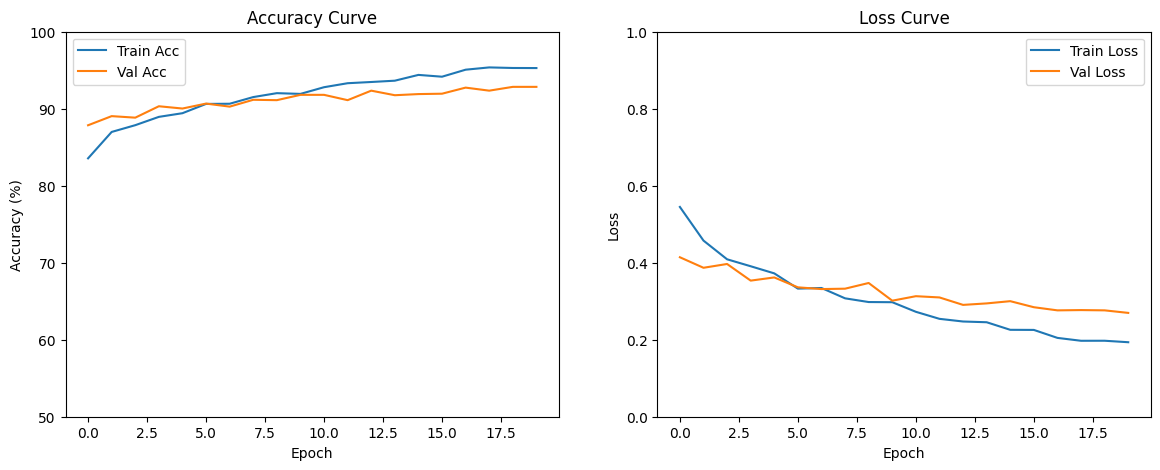

In [ ]:
# Plot Accuracy / Loss Curves with Y-axis 0–100%
def plot_training_curves(history, title="Training Curves"):
    plt.figure(figsize=(14,5))

    # -------------------- ACCURACY --------------------
    plt.subplot(1,2,1)
    train_acc = np.array(history.history['accuracy']) * 100
    val_acc = np.array(history.history['val_accuracy']) * 100

    plt.plot(train_acc, label="Train Acc")
    plt.plot(val_acc, label="Val Acc")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curve")
    plt.ylim(50, 100)       # set Y-axis from 50 to 100
    plt.legend()

    # -------------------- LOSS ------------------------
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.ylim(0, 1)  # and i set here from 0 to 1
    plt.legend()

    plt.show()


print("\nShowing Fine-Tune Training Curves:")
plot_training_curves(history_fine)


In [18]:
#  Predictions for Confusion Matrix & Classification Report

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
#  Classification Report 
print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(y_true, y_pred, target_names=class_names))



===== CLASSIFICATION REPORT =====
                          precision    recall  f1-score   support

        Aditi Rao Hydari       0.89      0.95      0.92       155
Adrienne Bailon-Houghton       0.92      0.90      0.91       120
    Alberto Núñez Feijóo       0.94      0.96      0.95       136
  Aleksander Kwaśniewski       0.98      0.94      0.96       128
  Aleksandra Kwaśniewska       0.94      0.91      0.93       125
            Alesha Dixon       0.97      0.87      0.92       132
            Alex Salmond       0.99      0.98      0.99       141
             Alexa Chung       0.97      0.90      0.93       124
 Alfredo Pérez Rubalcaba       0.98      0.97      0.97       131
          Aléxis Tsípras       0.98      0.95      0.97       134
             Amber Heard       0.85      0.92      0.88       146
               Amy Adams       0.86      0.90      0.88       141
         Andie MacDowell       0.92      0.91      0.91       131
             Boris Tadić       0.94     

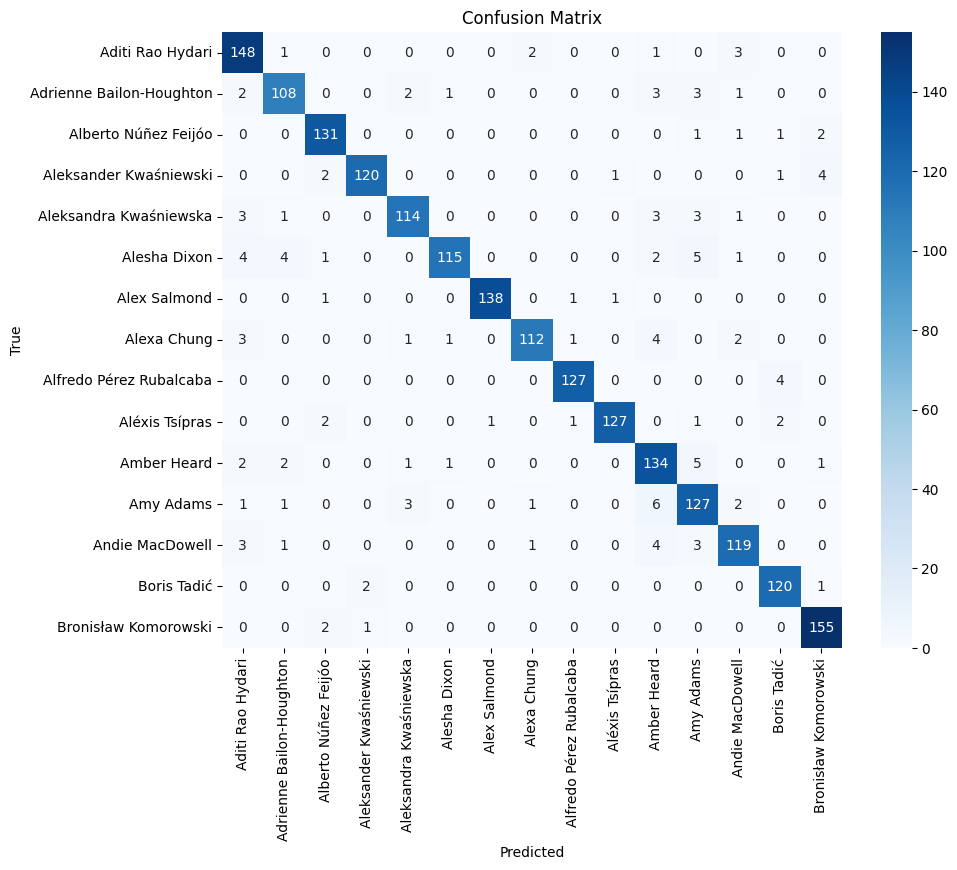

In [26]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

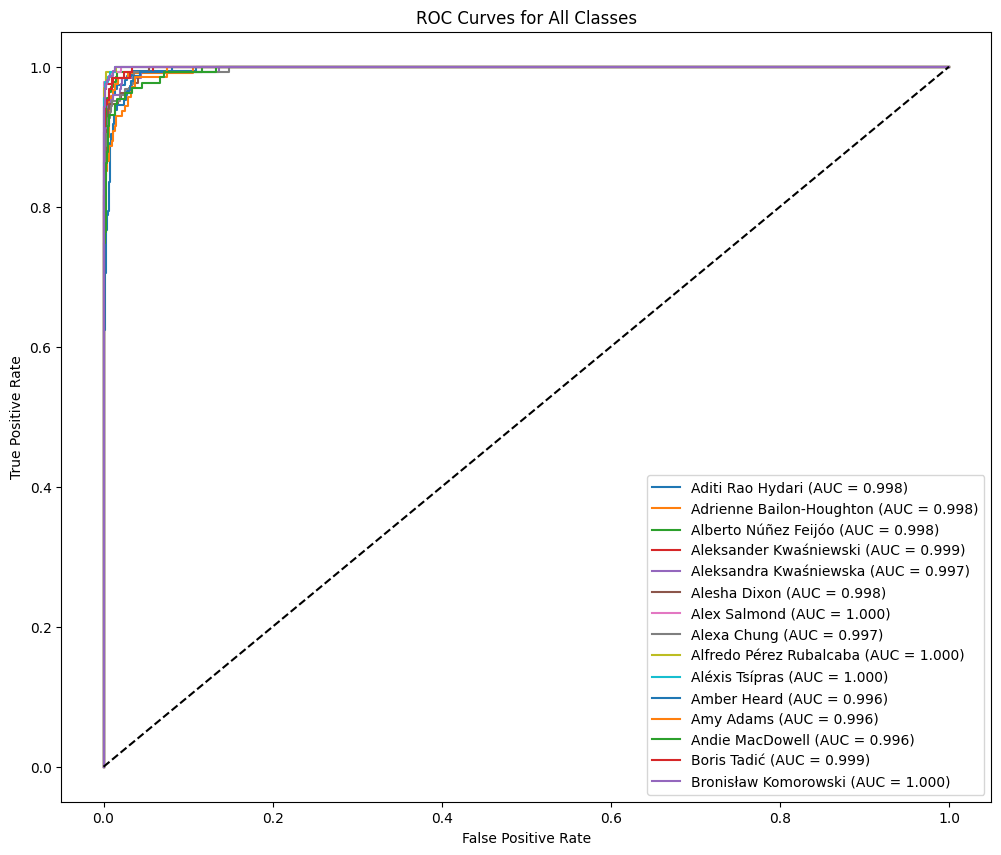

In [ ]:
#  ROC + AUC for the 15 classes
y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))

y_score = []
for images, _ in test_ds:
    y_score.append(model.predict(images))
y_score = np.vstack(y_score)

fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12,10))

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Classes")
plt.legend(loc="lower right")
plt.show()



In [28]:
#  get training accuracy to check if overfitting happened

y_true_train = []
y_pred_train = []

for images, labels in train_ds:
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    y_true_train.extend(labels.numpy())
    y_pred_train.extend(pred_classes)

y_true_train = np.array(y_true_train)
y_pred_train = np.array(y_pred_train)

print("Training predictions collected.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [29]:
#  Classification Report for training
print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(y_true_train, y_pred_train, target_names=class_names))



===== CLASSIFICATION REPORT =====
                          precision    recall  f1-score   support

        Aditi Rao Hydari       0.90      0.97      0.93       612
Adrienne Bailon-Houghton       0.98      0.93      0.95       646
    Alberto Núñez Feijóo       0.94      0.97      0.95       644
  Aleksander Kwaśniewski       0.98      0.98      0.98       635
  Aleksandra Kwaśniewska       0.95      0.94      0.94       620
            Alesha Dixon       0.98      0.93      0.95       634
            Alex Salmond       0.98      0.99      0.98       624
             Alexa Chung       0.99      0.94      0.97       638
 Alfredo Pérez Rubalcaba       1.00      1.00      1.00       636
          Aléxis Tsípras       1.00      0.94      0.97       630
             Amber Heard       0.91      0.97      0.94       610
               Amy Adams       0.93      0.96      0.94       625
         Andie MacDowell       0.96      0.96      0.96       619
             Boris Tadić       0.99     